# Transformer


In [1]:
import math
import time
import d2l
from mxnet import nd, autograd
from mxnet.gluon import nn, utils as gutils, data as gdata

## Multi-Head Attention

In [2]:
class MultiHeadAttention(nn.Block):
    def __init__(self, units, num_heads, dropout, **kwargs):  # units = d_o
        super(MultiHeadAttention, self).__init__(**kwargs)
        assert units % num_heads == 0
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Dense(units, use_bias=False, flatten=False)
        self.W_k = nn.Dense(units, use_bias=False, flatten=False)
        self.W_v = nn.Dense(units, use_bias=False, flatten=False)
            
    # query, key, and value shape: (batch_size, num_items, dim)
    # valid_length shape is either (bathc_size, ) or (batch_size, num_items)
    def forward(self, query, key, value, valid_length):
        # Project and transpose from (batch_size, num_items, units) to 
        # (batch_size * num_heads, num_items, p), where units = p * num_heads.
        query, key, value = [transpose_qkv(X, self.num_heads) for X in (
            self.W_q(query), self.W_k(key), self.W_v(value))]
        if valid_length is not None:
            # Copy valid_length by num_heads times
            if valid_length.ndim == 1: 
                valid_length = valid_length.tile(self.num_heads)
            else:
                valid_length = valid_length.tile((self.num_heads, 1))
        output = self.attention(query, key, value, valid_length)
        # Transpose from (batch_size * num_heads, num_items, p) back to       
        # (batch_size, num_items, units)
        return transpose_output(output, self.num_heads)

Definitions of the transpose functions.

In [3]:
def transpose_qkv(X, num_heads):
    # Shape after reshape: (batch_size, num_items, num_heads, p)
    # 0 means copying the shape element, -1 means inferring its value
    X = X.reshape((0, 0, num_heads, -1))
    # Swap the num_items and the num_heads dimensions
    X = X.transpose((0, 2, 1, 3))
    # Merge the first two dimensions. Use reverse=True to infer 
    # shape from right to left
    return X.reshape((-1, 0, 0), reverse=True)

def transpose_output(X, num_heads):
    # A reversed version of transpose_qkv
    X = X.reshape((-1, num_heads, 0, 0), reverse=True)
    X = X.transpose((0, 2, 1, 3))
    return X.reshape((0, 0, -1))

Example

In [4]:
cell = MultiHeadAttention(100, 10, 0.5)
cell.initialize()
X = nd.ones((2, 4, 5))
valid_length = nd.array([2,3])
cell(X, X, X, valid_length).shape

(2, 4, 100)

## Position-wise Feed-Forward Networks

In [5]:
class PositionWiseFFN(nn.Block):
    def __init__(self, units, hidden_size, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.ffn_1 = nn.Dense(hidden_size, flatten=False, activation='relu')
        self.ffn_2 = nn.Dense(units, flatten=False)

    def forward(self, X):
        return self.ffn_2(self.ffn_1(X))

Example

In [6]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(nd.ones((2, 3, 4)))[0]


[[ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]
 [ 0.00752072  0.00865059  0.01013744 -0.00906538]]
<NDArray 3x4 @cpu(0)>

## Add and Norm

Layer norm

In [7]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = nd.array([[1,2],[2,3]])
# compute mean and variance from X in the training mode.
with autograd.record():  
    print('layer norm:',layer(X), '\nbatch norm:', batch(X))

layer norm: 
[[-0.99998  0.99998]
 [-0.99998  0.99998]]
<NDArray 2x2 @cpu(0)> 
batch norm: 
[[-0.99998 -0.99998]
 [ 0.99998  0.99998]]
<NDArray 2x2 @cpu(0)>


The connection block

In [8]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm()
        
    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

Example

In [9]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(nd.ones((2,3,4)), nd.ones((2,3,4))).shape

(2, 3, 4)

## Positional Encoding

In [10]:
class PositionalEncoding(nn.Block):
    def __init__(self, units, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enougn P
        self.P = nd.zeros((1, max_len, units))
        X = nd.arange(0, max_len).reshape((-1,1)) / nd.power(
            10000, nd.arange(0, units, 2)/units) 
        self.P[:, :, 0::2] = nd.sin(X)
        self.P[:, :, 1::2] = nd.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_context(X.context)
        return self.dropout(X)


Visualize the position values

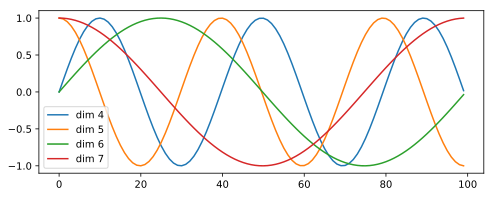

In [11]:
d2l.set_figsize((8, 3))
pe = PositionalEncoding(20, 0)
pe.initialize()
Y = pe(nd.zeros((1, 100, 20 )))
d2l.plt.plot(nd.arange(100).asnumpy(), Y[0, :,4:8].asnumpy())
d2l.plt.legend(["dim %d"%p for p in [4,5,6,7, 20]]);

## Encoder

The encoder block

In [12]:
class EncoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_2 = AddNorm(dropout)        
        
    def forward(self, X, valid_length):
        Y = self.add_1(X, self.attention(X, X, X, valid_length))
        return self.add_2(Y, self.ffn(Y))

Example

In [13]:
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(nd.ones((2, 100, 24)), valid_length).shape 

(2, 100, 24)

The encoder stacks $n$ blocks. 

In [14]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, units, hidden_size, 
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.units = units
        self.embed = nn.Embedding(vocab_size, units) 
        self.pos_encoding = PositionalEncoding(units, dropout)        
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                EncoderBlock(units, hidden_size, num_heads, dropout))
            
    def forward(self, X, valid_length, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X = blk(X, valid_length)
        return X

Example

In [15]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(nd.ones((2, 100)), valid_length).shape

(2, 100, 24)

## Decoder

In [16]:
class DecoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i  # i means it's the i-th block in the decoder
        self.attention_1 = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.attention_2 = MultiHeadAttention(units, num_heads, dropout)
        self.add_2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_3 = AddNorm(dropout)

    def forward(self, X, state):  
        enc_outputs, enc_valid_lengh = state[0], state[1]
        if state[2][self.i] is None:  # contains the past queries for this block 
            key_values = X  
        else:
            key_values = nd.concat(state[2][self.i], X, dim=1)
        state[2][self.i] = key_values
        if autograd.is_training():
            batch_size, seq_len, _ = X.shape
            # shape: (batch_size, seq_len), the values in the j-th column are j+1 
            valid_length = nd.arange(
                1, seq_len+1, ctx=X.context).tile((batch_size, 1))
        else:
            valid_length = None
            
        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.add_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_lengh)
        Z = self.add_2(Y, Y2)
        return self.add_3(Z, self.ffn(Z)), state

Example:

In [17]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = nd.ones((2, 100, 24))
state = [encoder_blk(X, valid_length), valid_length, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

The decoder:

In [18]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, units, hidden_size, 
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.units = units
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, units) 
        self.pos_encoding = PositionalEncoding(units, dropout)        
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(units, hidden_size, num_heads, dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)
    
    def init_state(self, enc_outputs, env_valid_lengh, *args):
        return [enc_outputs, env_valid_lengh, [None]*self.num_layers]    
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

## Training

In [19]:
embed_size, units, num_layers, dropout = 32, 32, 2, 0.0 
batch_size, num_examples, max_len = 64, 1024, 10
lr, num_epochs, ctx = 0.005, 200, d2l.try_gpu()
num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(
    batch_size, max_len, num_examples)

encoder = TransformerEncoder(
    len(src_vocab), units, num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(
    len(src_vocab), units, num_hiddens, num_heads, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_ch7(model, train_iter, lr, num_epochs, ctx)

epoch 50, loss 0.035, time 33.2 sec
epoch 100, loss 0.031, time 33.1 sec
epoch 150, loss 0.030, time 33.1 sec
epoch 200, loss 0.028, time 33.2 sec


Predict

In [20]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.translate_ch7(
        model, sentence, src_vocab, tgt_vocab, max_len, ctx))

Go . => va !
Wow ! => <unk> le <unk> à <unk> <unk> <unk> <unk> <unk> <unk>
I'm OK . => je vais bien .
I won ! => je l'ai emporté !
